In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import numpy as np
import pybaseball
import nutpie
import pytensor.tensor as pt
import pymc as pm
import preliz as pz
import arviz as az

# Batting average

- PC prior on lengthscale
- Binomial likelihood

Using the PC prior instead of the inverse gamma on the lengthscale to not bias the model towards picking up a non-existant age effect.  This can happen because the inverse gamma has a lighter right tail than the PC prior, and when a GP learns "no effect", it simultaneously sends the lengthscale large and the scale (`eta`) small. 

In [3]:
df = pd.read_csv("data/batting_2023.csv")
df.head()

,Unnamed: 0,Name,Age,#days,Lev,Tm,G,PA,AB,R,H,2B,3B,HR,RBI,BB,IBB,SO,HBP,SH,SF,GDP,SB,CS,BA,OBP,SLG,OPS,mlbID
0,1,CJ Abrams,22,426,Maj-NL,Washington,150,610,559,83,138,28,6,18,64,32,2,117,13,3,3,7,47,4,0.247,0.302,0.415,0.717,682928
1,2,Jos\xc3\xa9 Abreu,36,426,Maj-AL,Houston,139,586,533,61,126,23,1,18,90,41,1,129,6,0,6,16,0,1,0.236,0.295,0.385,0.680,547989
2,3,Wilyer Abreu,24,426,Maj-AL,Boston,28,85,76,10,24,6,0,2,14,9,0,23,0,0,0,0,3,1,0.316,0.388,0.474,0.862,677800
3,4,Ronald Acu\xc3\xb1a Jr.,25,426,Maj-NL,Atlanta,158,729,637,149,215,35,4,41,106,80,3,84,9,0,3,15,71,14,0.338,0.417,0.598,1.015,660670
4,5,Willy Adames,27,426,Maj-NL,Milwaukee,148,634,550,73,119,29,2,24,80,70,1,165,6,0,6,11,5,3,0.216,0.309,0.407,0.716,642715


In [125]:
ix_team, team = pd.factorize(df.Tm, sort=True)
ix_age, age = pd.factorize(df.Age, sort=True)
ix_player, player = pd.factorize(df.Name, sort=True)

coords = {
    "name": df.Name,
    "age": age,
    "team": team,
    "player": player,
}

with pm.Model(coords=coords) as model:
    intercept = pm.Normal("intercept", mu=0.0, sigma=2.0)

    alpha_scale, upper_scale = 0.01, 0.25
    sigma_team = pm.Exponential("sigma_team", lam=-np.log(alpha_scale) / upper_scale)
    delta_team = pm.ZeroSumNormal("delta_team", sigma=sigma_team, dims="team")
    
    alpha_scale, upper_scale = 0.01, 0.25
    sigma_player = pm.Exponential("sigma_player", lam=-np.log(alpha_scale) / upper_scale)
    delta_player = pm.ZeroSumNormal("delta_player", sigma=sigma_player, dims="player")
    
    alpha_scale, upper_scale = 0.01, 0.25
    eta = pm.Exponential(name="eta", lam=-np.log(alpha_scale) / upper_scale)
    
    ## PC prior for lengthscale
    input_dim = 1.0
    alpha_ell, lower_ell = 0.05, 5.0
    lam_ell = -np.log(alpha_ell) * (lower_ell**(0.5 * input_dim))
    alpha = input_dim / 2
    beta = 1.0 / (lam_ell ** (2 / input_dim))
    ell_inv = pm.Weibull(name="ell_inv", alpha=alpha, beta=beta)
    ell = pm.Deterministic("ell", 1 / ell_inv)
    
    cov_func = eta**2 * pm.gp.cov.Matern52(1, ls=ell)
    
    gp = pm.gp.HSGP(m=[100], c=3.0, cov_func=cov_func)
    X = np.sort(df.Age.unique())[:, None]
    phi, sqrt_psd = gp.prior_linearized(X=X)
    phi = phi - pt.mean(phi, axis=0)
    beta = pm.Normal("beta", size=gp.n_basis_vectors)
    f = pm.Deterministic("f", phi @ (beta * sqrt_psd), dims="age")
    
    logit_p = intercept + f[ix_age] + delta_team[ix_team] + delta_player[ix_player]
    pm.Binomial("hits", logit_p=logit_p, n=df.AB.values, observed=df.H.values)
    
    age_effect = pm.Deterministic("age_effect", pm.math.sigmoid(intercept + f), dims="age")

In [126]:
import nutpie
compiled_model = nutpie.compile_pymc_model(model, backend="jax")
sampler = nutpie.sample(
    compiled_model,
    blocking=False,
    target_accept=0.95,
    tune=500,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,0,0.12,31
,1500,0,0.15,31
,1500,0,0.13,31
,1500,0,0.06,127
,1500,0,0.11,31
,1500,0,0.13,31


In [127]:
idata = sampler.wait()

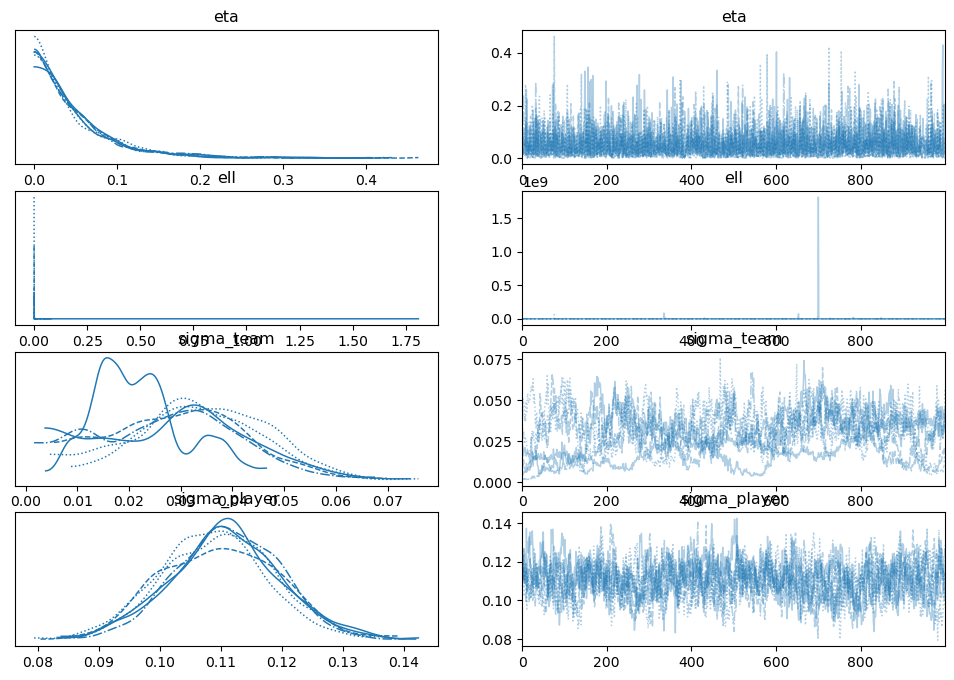

In [130]:
az.plot_trace(idata, var_names=["eta", "ell", "sigma_team", "sigma_player"]);

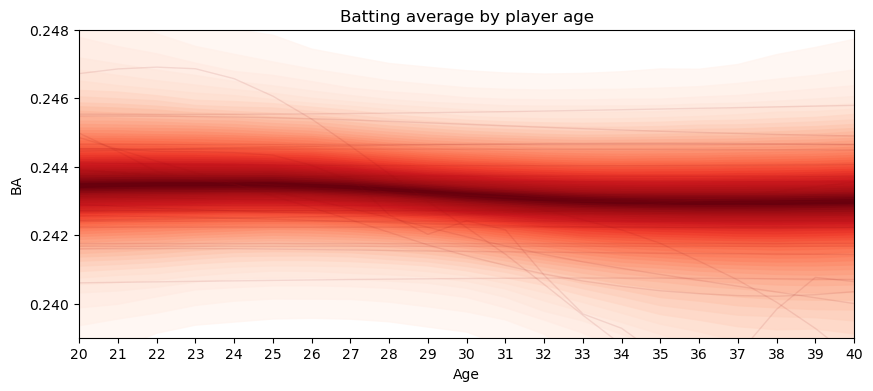

In [133]:
f = az.extract(idata, var_names="age_effect")

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
pm.gp.util.plot_gp_dist(x=X.flatten(), samples=f.T, ax=ax);
ax.set_xticks(X.flatten());
ax.set_xlim([20, 40]);
ax.set_ylim([0.239, 0.248])
ax.set_xlabel("Age");
ax.set_ylabel("BA");
ax.set_title("Batting average by player age");

Looks like there is a _very_ weak age effect here.

# Batting average

- PC prior on lengthscale
- Beta-Binomial likelihood

In [135]:
df = pd.read_csv("../data/batting_2023.csv")

In [136]:
ix_team, team = pd.factorize(df.Tm, sort=True)
ix_age, age = pd.factorize(df.Age, sort=True)
ix_player, player = pd.factorize(df.Name, sort=True)

coords = {
    "name": df.Name,
    "age": age,
    "team": team,
    "player": player,
}

with pm.Model(coords=coords) as model:
    intercept = pm.Normal("intercept", mu=0.0, sigma=2.0)

    alpha_scale, upper_scale = 0.01, 0.25
    sigma_team = pm.Exponential("sigma_team", lam=-np.log(alpha_scale) / upper_scale)
    delta_team = pm.ZeroSumNormal("delta_team", sigma=sigma_team, dims="team")
    
    alpha_scale, upper_scale = 0.01, 0.25
    sigma_player = pm.Exponential("sigma_player", lam=-np.log(alpha_scale) / upper_scale)
    delta_player = pm.ZeroSumNormal("delta_player", sigma=sigma_player, dims="player")
    
    alpha_scale, upper_scale = 0.01, 0.25
    eta = pm.Exponential(name="eta", lam=-np.log(alpha_scale) / upper_scale)
    input_dim = 1.0
    alpha_ell, lower_ell = 0.05, 5.0
    lam_ell = -np.log(alpha_ell) * (lower_ell**(0.5 * input_dim))
    alpha = input_dim / 2
    beta = 1.0 / (lam_ell ** (2 / input_dim))
    ell_inv = pm.Weibull(name="ell_inv", alpha=alpha, beta=beta)
    ell = pm.Deterministic("ell", 1 / ell_inv)
    
    cov_func = eta**2 * pm.gp.cov.Matern52(1, ls=ell)
    
    gp = pm.gp.HSGP(m=[100], c=3.0, cov_func=cov_func)
    X = np.sort(df.Age.unique())[:, None]
    phi, sqrt_psd = gp.prior_linearized(X=X)
    phi = phi - pt.mean(phi, axis=0)
    beta = pm.Normal("beta", size=gp.n_basis_vectors)
    f = pm.Deterministic("f", phi @ (beta * sqrt_psd), dims="age")
    
    logit_p = intercept + f[ix_age] + delta_team[ix_team] + delta_player[ix_player]
    mu = pm.Deterministic("mu", pm.math.sigmoid(logit_p))
    kappa = pm.Exponential("kappa", scale=500)
    pm.BetaBinomial("hits", alpha=mu*kappa, beta=(1 - mu)*kappa, n=df.AB.values, observed=df.H.values)
    
    age_effect = pm.Deterministic("age_effect", pm.math.sigmoid(intercept + f), dims="age")

In [137]:
import nutpie
compiled_model = nutpie.compile_pymc_model(model, backend="jax")
sampler = nutpie.sample(
    compiled_model,
    blocking=False,
    target_accept=0.95,
    tune=500,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,0,0.11,511
,1500,0,0.10,31
,1500,0,0.11,31
,1500,0,0.12,415
,1500,0,0.13,63
,1500,0,0.06,255


In [138]:
idata = sampler.wait()

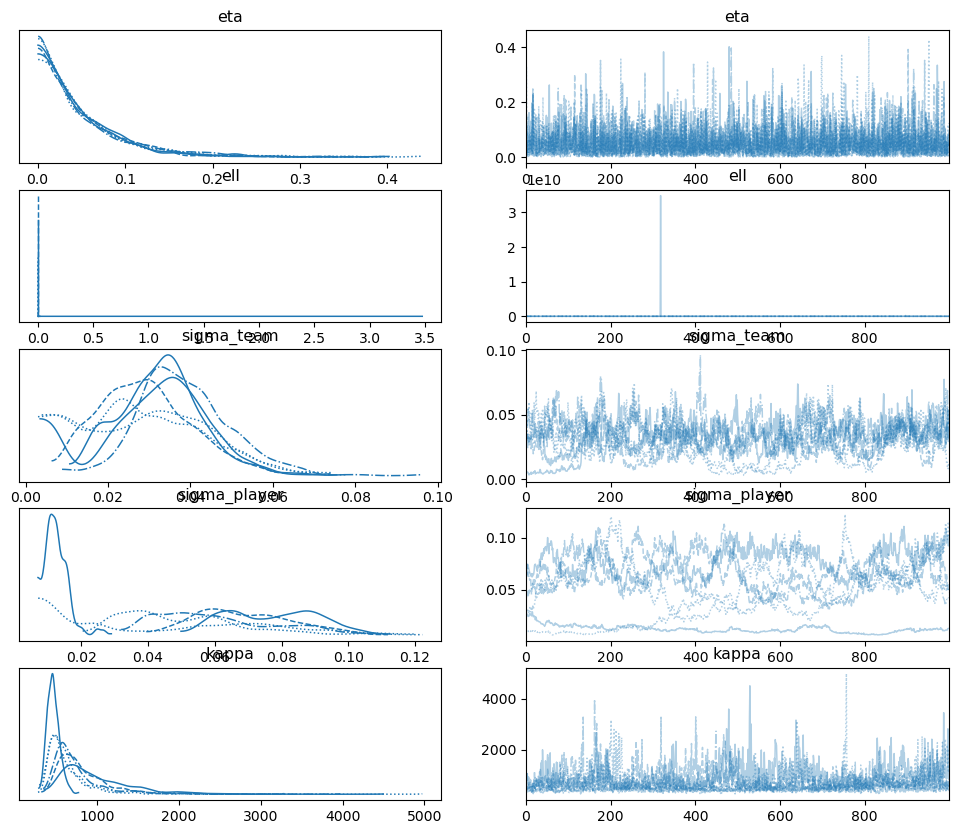

In [139]:
az.plot_trace(idata, var_names=["eta", "ell", "sigma_team", "sigma_player", "kappa"]);

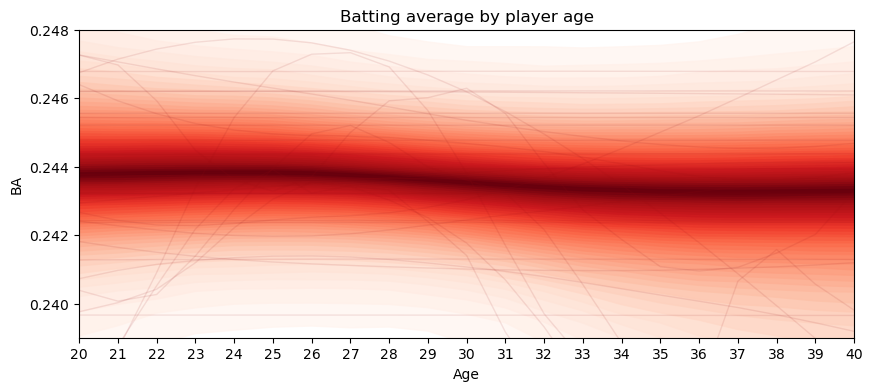

In [140]:
f = az.extract(idata, var_names="age_effect")

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
pm.gp.util.plot_gp_dist(x=X.flatten(), samples=f.T, ax=ax);
ax.set_xticks(X.flatten());
ax.set_xlim([20, 40]);
ax.set_ylim([0.239, 0.248])
ax.set_xlabel("Age");
ax.set_ylabel("BA");
ax.set_title("Batting average by player age");

Looks like it weakens a little bit when allowing for overdispersion.

# SLG

Using a Poisson model with an offet to handle SLG as a rate.  Number of bases per at bat.

I found that using the Poisson likelihood isn't quite as good as the Negative Binomial.  Looks like there's a fairly small amount of overdispersion (maybe because of unmodeled variance since the models pretty simplistic).

In [4]:
try:
    df = pd.read_csv("data/slg_10years.csv")
    df["bases"] = df["bases"].astype(int)
    
except:

    df = pybaseball.batting_stats(start_season="2014", end_season="2024", league='all', qual=1, ind=1)
    df = df[df.AB > 0]
    #df = pybaseball.batting_stats("2023", league='all', qual=1, ind=1)
    bases = np.round(df["AB"] * df["SLG"])
    df["slg"] = bases / df["AB"]
    df["bases"] = np.asarray(bases, dtype=int)
    
    df.to_csv("../data/slg_10years.csv", index=False)

In [5]:
cols = ["Season", "Name", "Team", "Age", "AB", "slg", "bases"]
df[df.Name.str.contains("Ichiro")][cols].sort_values("Season")

,Season,Name,Team,Age,AB,slg,bases
2158,2014,Ichiro Suzuki,NYY,40,359,0.339833,122
9098,2015,Ichiro Suzuki,MIA,41,398,0.278894,111
1638,2016,Ichiro Suzuki,MIA,42,327,0.376147,123
7972,2017,Ichiro Suzuki,MIA,43,196,0.331633,65
8892,2018,Ichiro Suzuki,SEA,44,44,0.204545,9
7032,2019,Ichiro Suzuki,SEA,45,5,0.000000,0


In [44]:
ix_team, team = pd.factorize(df.Team, sort=True)
ix_age, age = pd.factorize(df.Age, sort=True)
ix_player, player = pd.factorize(df.Name, sort=True)
ix_year, year = pd.factorize(df.Season, sort=True)

coords = {
    "age": age,
    "team": team,
    "player": player,
    "year": year,
}

with pm.Model(coords=coords) as model:
    intercept = pm.Normal("intercept", mu=0.0, sigma=2.0)

    alpha_scale, upper_scale = 0.01, 0.1
    sigma_team = pm.Exponential("sigma_team", lam=-np.log(alpha_scale) / upper_scale)
    delta_team = pm.ZeroSumNormal("delta_team", sigma=sigma_team, dims="team")

    alpha_scale, upper_scale = 0.01, 0.5
    sigma_player = pm.Exponential("sigma_player", lam=-np.log(alpha_scale) / upper_scale)
    #sigma_player = pm.Gamma("sigma_player", alpha=2, beta=30)
    #delta_player = pm.ZeroSumNormal("delta_player", sigma=sigma_player, dims="player")
    player_effect = pm.Normal("player_effect", mu=intercept, sigma=sigma_player, dims="player")
    
    
    alpha_scale, upper_scale = 0.01, 0.5
    sigma_year = pm.Exponential("sigma_year", lam=-np.log(alpha_scale) / upper_scale)
    #sigma_player = pm.Gamma("sigma_player", alpha=2, beta=30)
    delta_year = pm.ZeroSumNormal("delta_year", sigma=sigma_year, dims="year")

    alpha_scale, upper_scale = 0.01, 0.2
    eta = pm.Exponential(name="eta", lam=-np.log(alpha_scale) / upper_scale)

    # inverse gamma lengthscale prior
    #ell = pz.maxent(
    #    pz.InverseGamma(), lower=5, upper=25, mass=0.95, plot=False
    #).to_pymc("ell")

    #""" PC lengthscale prior
    input_dim = 1.0
    alpha_ell, lower_ell = 0.025, 5.0
    lam_ell = -np.log(alpha_ell) * (lower_ell**(0.5 * input_dim))
    alpha = input_dim / 2
    beta = 1.0 / (lam_ell ** (2 / input_dim))
    ell_inv = pm.Weibull(name="ell_inv", alpha=alpha, beta=beta)
    ell = pm.Deterministic("ell", 1 / ell_inv)
    #"""

    cov_func = eta**2 * pm.gp.cov.Matern52(1, ls=ell)

    gp = pm.gp.HSGP(m=[100], c=3.0, cov_func=cov_func)
    X = np.sort(df.Age.unique())[:, None]
    phi, sqrt_psd = gp.prior_linearized(X=X)
    phi = phi - pt.mean(phi, axis=0)
    beta = pm.Normal("beta", size=gp.n_basis_vectors)

    f = pm.Deterministic("f", phi @ (beta * sqrt_psd), dims="age")

    bases_exp = pm.Deterministic(
        "bases_exp", 
        pm.math.exp(
            np.log(df.AB.values) + 
            #intercept + 
            f[ix_age] + 
            player_effect[ix_player] +
            delta_team[ix_team] +
            delta_year[ix_year]
            #delta_player[ix_team]
        ), 
    )

    #"""
    epsilon, L = 0.05, 10
    def pc_negbinom_kld_distance_inv(alpha):
        return pt.sqrt(2.0 * (pt.log(1.0 / alpha) - pt.digamma(1.0 / alpha)))
    # This PC prior can be constructed in PyMC by transforming a Weibull
    lam = -np.log(epsilon) / pc_negbinom_kld_distance_inv(1 / L)
    alpha = pm.Deterministic("alpha", 1 / pm.Weibull("alpha_", alpha=0.5, beta=1.0 / lam**2))
    pm.NegativeBinomial("bases", mu=bases_exp, alpha=alpha, observed=df.bases.values)
    #"""
    #pm.Poisson("bases", mu=bases_exp, observed=df.bases.values)
    
    slg = pm.Deterministic("slg", pt.exp(intercept + f), dims="age")
    

with model:
    idata = pm.sample_prior_predictive(samples=10_000)

Sampling: [alpha_, bases, beta, delta_team, delta_year, ell_inv, eta, intercept, player_effect, sigma_player, sigma_team, sigma_year]


In [55]:
ell = az.extract(idata.prior, var_names="ell");
plt.hist(ell.data, bins=np.linspace(0, 35, 100));
plt.title("lenthscale prior")

AttributeError: 'InferenceData' object has no attribute 'prior'

In [46]:
import nutpie
compiled_model = nutpie.compile_pymc_model(model, backend="jax")
sampler = nutpie.sample(
    compiled_model,
    blocking=False,
    target_accept=0.95,
    tune=500,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,0,0.08,63
,1500,0,0.09,63
,1500,0,0.09,63
,1500,0,0.09,63
,1500,0,0.09,63
,1500,0,0.10,63


In [47]:
idata = sampler.wait()

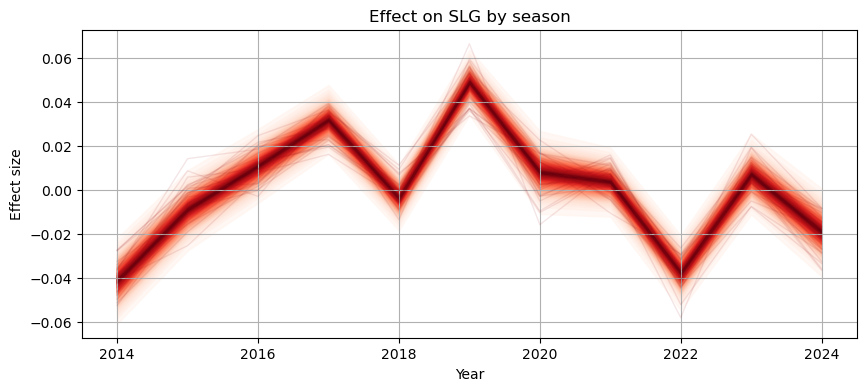

In [49]:
f = az.extract(idata, var_names="delta_year")

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
pm.gp.util.plot_gp_dist(x=np.sort(df.Season.unique()), samples=f.T, ax=ax);
#ax.set_xticks(X.flatten());
#ax.set_xlim([X.min(), X.max()]);
ax.set_xlabel("Year");
ax.set_ylabel("Effect size");
ax.set_title("Effect on SLG by season");
ax.grid(True);
#ax.set_ylim([0.35, 0.40]);

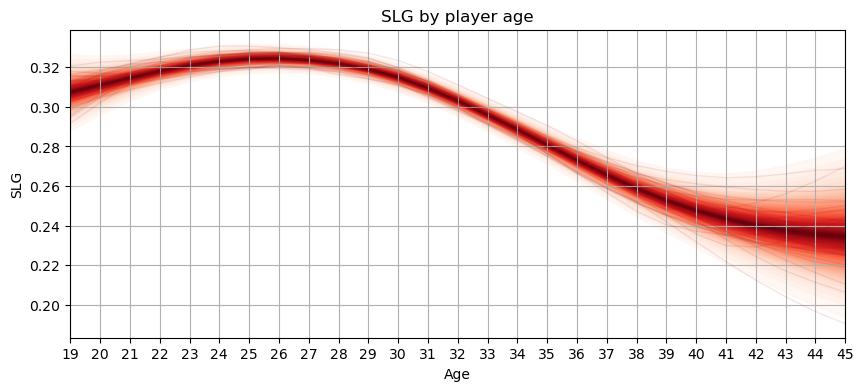

In [50]:
f = az.extract(idata, var_names="slg")

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
pm.gp.util.plot_gp_dist(x=X.flatten(), samples=f.T, ax=ax);
ax.set_xticks(X.flatten());
ax.set_xlim([X.min(), X.max()]);
ax.set_xlabel("Age");
ax.set_ylabel("SLG");
ax.set_title("SLG by player age");
ax.grid(True);
#ax.set_ylim([0.35, 0.40]);

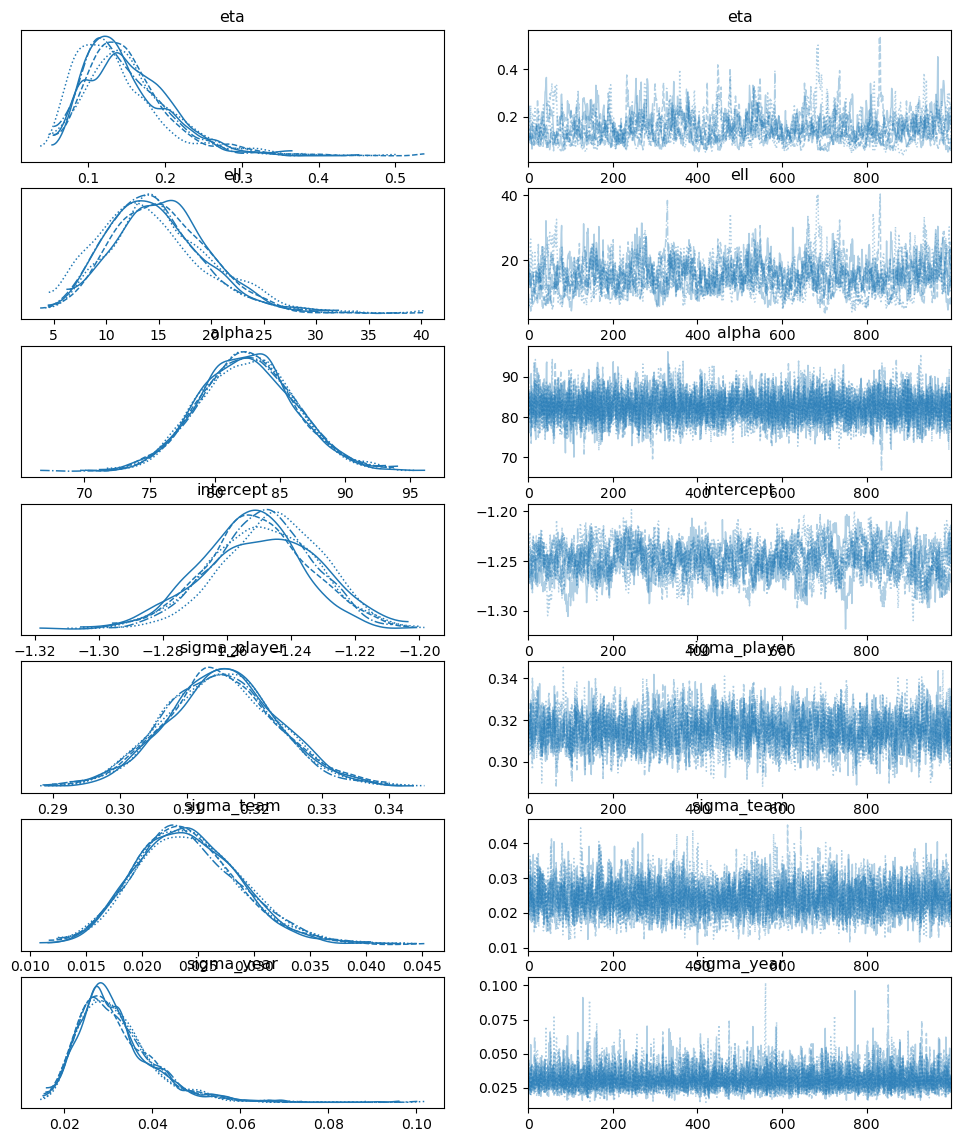

In [51]:
az.plot_trace(idata, var_names=["eta", "ell", "alpha", "intercept", "sigma_player", "sigma_team", "sigma_year"]);

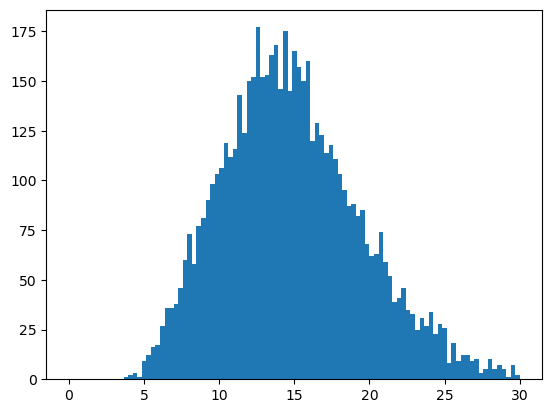

In [52]:
s = az.extract(idata, var_names="ell").data.flatten();
plt.hist(s, bins=np.linspace(0, 30, 100));

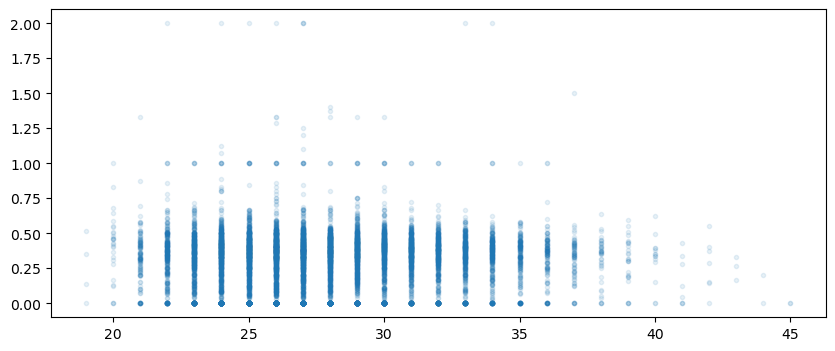

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(df.Age, df.slg, '.', alpha=0.1);